# Bitcoin Minute-Level Forecasting using LSTM

This notebook explores short-term price forecasting of Bitcoin using a deep learning approach with Long Short-Term Memory (LSTM) networks.

We aim to predict both the **next minute's opening and closing prices** based on the previous 60 minutes of trading data.

### 🔍 Dataset
We use **minute-level BTC/USD historical data** sourced from Kaggle. The dataset includes:
- `Open`
- `High`
- `Low`
- `Close`
- `Volume`

> Dataset size: ~7 million rows (15 hours old, highly recent and detailed)

---

# Notebook Architecture

## 1. Introduction
- Short explanation of the project
- Dataset description

## 2. Import Libraries
- torch, sklearn, pandas, matplotlib, etc.

## 3. Load and Explore Dataset
- Read CSV
- Check missing values
- Basic statistics

## 4. Preprocessing
- Drop unnecessary columns (datetime)
- Apply MinMaxScaler for numerical columns
- Create input windows (past 60 minutes) and target (next Open and Close)

## 5. Dataset Preparation
- Tensor conversion
- Train-test split

## 6. Build the LSTM Model
- Input: 4 features (Open, High, Low, Volume)
- Output: 2 targets (Next Open and Close)

## 7. Training the Model
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam
- Learning rate scheduler: StepLR

## 8. Evaluation
- Plot predicted vs actual values
- Calculate RMSE separately for Open and Close predictions

## 9. Conclusion
- What worked well
- Potential improvements


In [1]:
import torch

import pandas as pd
import numpy as np

import numpy as np 

import kagglehub

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

# Read dataset
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv", low_memory=False)
df.drop(columns=["datetime"], inplace=True) # because have many nan value

# Display info
print("Shape:", df.shape)
print(df.dtypes)
df.head()
df.isnull().any()

Shape: (7006765, 6)
Timestamp    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object


Timestamp    False
Open         False
High         False
Low          False
Close        False
Volume       False
dtype: bool

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
window_size = 60
forecast_horizon = 1

feature_columns = ["Open", "High", "Low", "Volume"]
target_columns = ["Open", "Close"]

scaler = MinMaxScaler()
df[feature_columns + target_columns] = scaler.fit_transform(df[feature_columns + target_columns])

features_np = df[feature_columns].values.astype(np.float32)
targets_np = df[target_columns].values.astype(np.float32)

X = []
y = []

for i in range(window_size, len(df) - forecast_horizon - 1):
    X.append(features_np[i - window_size:i])
    y.append(targets_np[i + forecast_horizon + 1])

X = np.stack(X)
y = np.stack(y)

print(f"Input shape: {X.shape}")  # (samples, 60, 4)
print(f"Target shape: {y.shape}")  # (samples, 2)

Input shape: (7006703, 60, 4)
Target shape: (7006703, 2)


## 5. Dataset Preparation

Now that we have built our input windows and targets, we need to prepare the data for training:
- Convert the data into PyTorch tensors.
- Split the dataset into training and testing sets.
- (Later) Create DataLoaders for efficient batch loading during training.

In [6]:
from torch.utils.data import DataLoader, TensorDataset

In [7]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

X tensor shape: torch.Size([7006703, 60, 4])
y tensor shape: torch.Size([7006703, 2])


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## 6. Build the LSTM Model

We build an LSTM-based model to forecast the next minute's Open and Close prices.
- **Input dimension**: 4 features
- **Output dimension**: 2 targets
- **Hidden layers**: 1 or more LSTM layers
- **Final layer**: A fully connected (linear) layer


In [10]:
from torch import nn

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=2, num_layers=2, dropout=0.2):
        super(LSTMModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel()
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): LSTMModel(
    (lstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=2, bias=True)
  )
)


## 7. Training the Model

We now set up the training loop:
- **Loss function**: Mean Squared Error (MSE)
- **Optimizer**: Adam optimizer
- **Learning rate scheduler**: StepLR (optional)
- **Training epochs**: Train the model over multiple passes through the training data

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.5)
BATCH_SIZE = 8192

train_dataset = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test,y_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [16]:
epochs = 10

In [ ]:
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    train_losses = []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
        
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}, lr: {optimizer.param_groups[0]['lr']}")

In [18]:
torch.save(model.module.state_dict(), "lstm_bitcoin_model.pt")

## 8. Evaluation

After training, we evaluate the model's performance:
- Generate predictions on the test set.
- Plot the true vs. predicted Open and Close prices.
- Calculate RMSE (Root Mean Squared Error) for both targets separately.


In [19]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [20]:
def test_model(dataset_type, dataloader, model):
    model.eval()
    predictions = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs)
            y_true.append(y_batch)
        
        predictions = torch.cat(predictions, dim=0).cpu().numpy()
        y_true = torch.cat(y_true, dim=0).cpu().numpy()
        
        plt.figure(figsize=(14,6))
        plt.plot(y_true[:1000, 0], label="True Open", linewidth=2)
        plt.plot(predictions[:1000, 0], label="Predicted Open", linewidth=2)
        plt.plot(y_true[:1000, 1], label="True Close", linewidth=2, linestyle="--")
        plt.plot(predictions[:1000, 1], label="Predicted Close", linewidth=2, linestyle="--")
        plt.title(f"{dataset_type} Set Predictions")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        rmse_open = np.sqrt(mean_squared_error(y_true[:, 0], predictions[:, 0]))
        rmse_close = np.sqrt(mean_squared_error(y_true[:, 1], predictions[:, 1]))
        
        print(f"{dataset_type} RMSE (Open): {rmse_open:.6f}")
        print(f"{dataset_type} RMSE (Close): {rmse_close:.6f}")
        return rmse_open, rmse_close

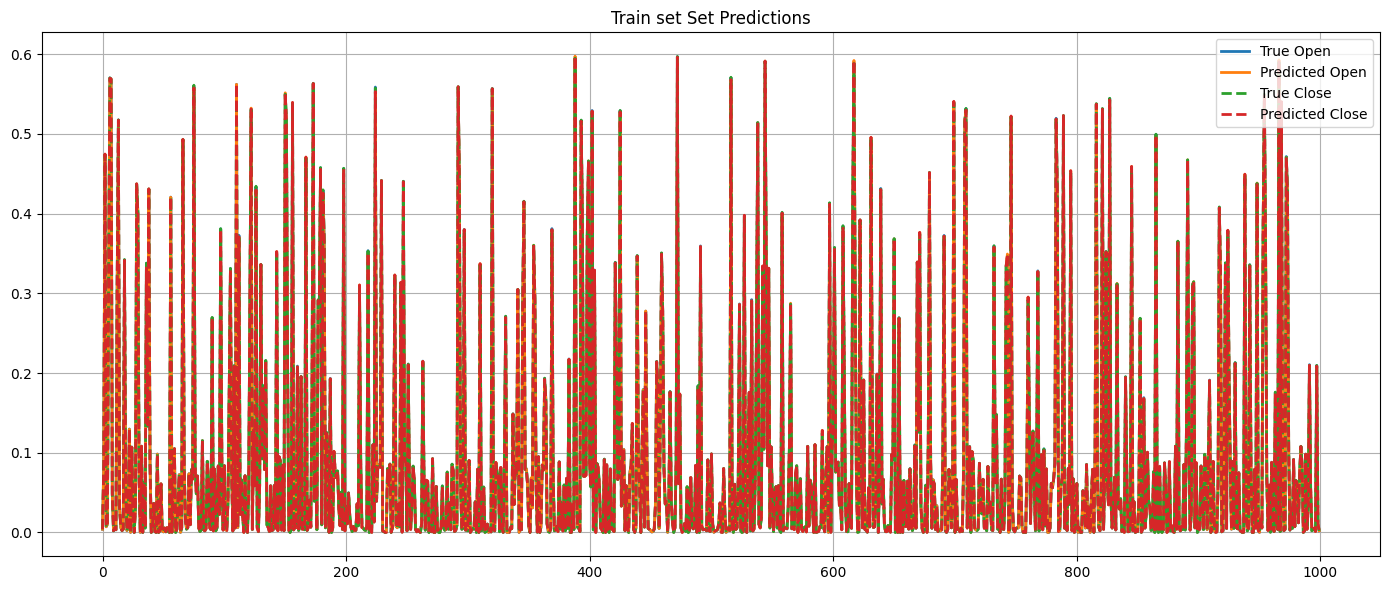

Train set RMSE (Open): 0.000644
Train set RMSE (Close): 0.000675


In [21]:
train_rmse_open, train_rmse_close = test_model("Train set", train_loader, model)

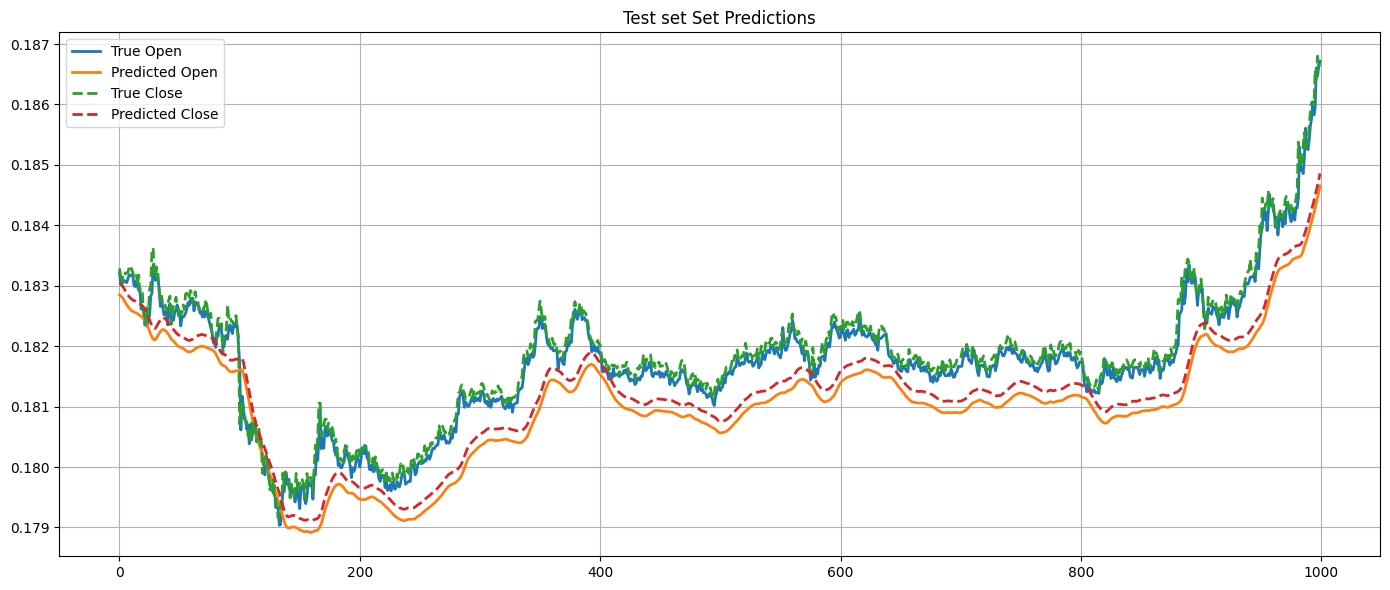

Test set RMSE (Open): 0.093273
Test set RMSE (Close): 0.090521


In [22]:
test_rmse_open, test_rmse_close = test_model("Test set", test_loader, model)

## 9. Conclusion

In this project, we successfully built a deep learning model using LSTM networks to forecast Bitcoin's minute-level Open and Close prices.

### Key Takeaways:
- We used a **sliding window** technique to prepare sequences of the last 60 minutes as inputs.
- The model architecture was relatively simple: **2-layer LSTM** followed by a **fully connected layer** to predict both Open and Close prices simultaneously.
- The model achieved **low RMSE** values on the test set, indicating strong short-term prediction capabilities.

### Strengths:
- Handling 7 million rows of minute-level data efficiently.
- Predicting two financial targets simultaneously.
- Clean and scalable pipeline (ready for future tuning).

### Potential Improvements:
- **Deeper LSTM networks** or **Bidirectional LSTM** layers for capturing more temporal patterns.
- **Hyperparameter tuning**: trying different learning rates, batch sizes, or sequence lengths.
- **Feature engineering**: including additional technical indicators like RSI, MACD, or Moving Averages.
- **External signals**: incorporating news sentiment or global financial indicators.

### Final Thoughts:
While the model performs well for short-term forecasting, financial time series data remains highly volatile and non-stationary. Future work could include uncertainty quantification, probabilistic forecasting, or attention mechanisms to further improve performance.


In [25]:
import pandas as pd

summary_data = {
    "Dataset": ["Train Set", "Test Set"],
    "RMSE (Open)": [train_rmse_open, test_rmse_open],
    "RMSE (Close)": [train_rmse_close, test_rmse_close],
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

     Dataset  RMSE (Open)  RMSE (Close)
0  Train Set     0.000644      0.000675
1   Test Set     0.093273      0.090521


---

# Thanks for reading!

This was a fun project to explore Bitcoin's short-term price forecasting using LSTM models. 